In [1]:
# 10-3

import numpy as np
import cv2
import sys
from sort import Sort

def construct_yolo_v3():
    with open('coco_names.txt', 'r') as f:
        class_names = [line.strip() for line in f.readlines()]

    model = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')
    layer_names = model.getLayerNames()
    

    unconnected_out_layers = model.getUnconnectedOutLayers()
    if isinstance(unconnected_out_layers, np.ndarray):
        out_layers = [layer_names[i - 1] for i in unconnected_out_layers.flatten()]
    else:
        out_layers = [layer_names[unconnected_out_layers - 1]]

    return model, out_layers, class_names

def yolo_detect(img, yolo_model, out_layers):
    height, width = img.shape[0], img.shape[1]
    test_img = cv2.dnn.blobFromImage(img, 1.0 / 256, (448, 448), (0,0,0), swapRB=True)
    yolo_model.setInput(test_img)
    output3 = yolo_model.forward(out_layers)

    box, conf, id = [], [], []
    for output in output3:
        for vec85 in output:
            scores = vec85[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:  # confidence 50% 초과 ==> 임계값
                centrex, centery = int(vec85[0] * width), int(vec85[1] * height)
                w, h = int(vec85[2] * width), int(vec85[3] * height)
                x, y = int(centrex - w/2), int(centery - h/2)
                box.append([x, y, x + w, y + h])
                conf.append(float(confidence))
                id.append(class_id)
    
    ind = cv2.dnn.NMSBoxes(box, conf, 0.5, 0.4)
    if len(ind) > 0:
        ind = ind.flatten() 
        objects = [box[i] + [conf[i]] + [id[i]] for i in ind]
    else:
        objects = []
    return objects

model, out_layers, class_names = construct_yolo_v3()
colors = np.random.uniform(0, 255, size=(100, 3))

sort = Sort()

cap = cv2.VideoCapture(1) 
if not cap.isOpened():
    sys.exit('카메라 연결 실패')

while True:
    ret, frame = cap.read()
    if not ret:
        sys.exit('프레임 획득 실패, 루프 탈출')

    res = yolo_detect(frame, model, out_layers)
    persons = [res[i] for i in range(len(res)) if res[i][5] == 0]

    if len(persons) == 0:
        tracks = sort.update()
    else:
        tracks = sort.update(np.array(persons))

    for i in range(len(tracks)):
        x1, y1, x2, y2, track_id = tracks[i].astype(int)
        cv2.rectangle(frame, (x1, y1), (x2, y2), colors[track_id % 100], 2) 
        cv2.putText(frame, str(track_id), (x1 + 10, y1 + 40), cv2.FONT_HERSHEY_PLAIN, 3, colors[track_id % 100], 2)

    cv2.imshow('Person tracking by SORT', frame)

    key = cv2.waitKey(1)
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [2]:
# 10-4

import cv2
import mediapipe as mp


img = cv2.imread('BSDS_376001.jpg')

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

face_detection = mp_face_detection.FaceDetection(model_selection = 1, min_detection_confidence = 0.5)
res = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

if not res.detections:
    print('extract x, try again')

else:
    for detection in res.detections:
        mp_drawing.draw_detection(img, detection)
    cv2.imshow('Face detction by mp', img)

cv2.waitKey()
cv2.destroyAllWindows()

c:\Users\rch\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [7]:
# 10-5

import cv2
import mediapipe as mp



mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

face_detection = mp_face_detection.FaceDetection(model_selection = 1, min_detection_confidence = 0.5)
cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)

while True:
    ret, frame = cap.read()
    if not ret:
        print('프레임 획득 x, 루프 탈출')
        break

    res = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if res.detections:
        for detection in res.detections:
            mp_drawing.draw_detection(frame, detection)


    cv2.imshow('MP face detection video', cv2.flip(frame, 1))
    if cv2.waitKey(5) == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

c:\Users\rch\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [8]:
# 10-6

import cv2
import mediapipe as mp

dice = cv2.imread('dice.png', cv2.IMREAD_UNCHANGED) # 장신구 그림 설정
dice = cv2.resize(dice, dsize = (0,0), fx = 0.1, fy = 0.1)
w, h = dice.shape[1], dice.shape[0]

mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

face_detection = mp_face_detection.FaceDetection(model_selection = 1, min_detection_confidence = 0.5)

cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)

while True:
    ret, frame = cap.read()
    if not ret:
        print('프레임 획득 실패, 루프 탈출')
        break

    res = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if res.detections:
        for det in res.detections:
            p = mp_face_detection.get_key_point(det, mp_face_detection.FaceKeyPoint.RIGHT_EYE)

            x1, x2 = int(p.x*frame.shape[1] - w//2), int(p.x*frame.shape[1] + w//2)
            y1, y2 = int(p.y*frame.shape[0] - h//2), int(p.y*frame.shape[0] + h//2)

            if x1 > 0 and y1 > 0 and x2 < frame.shape[1] and y2 < frame.shape[0]:
                alpha = dice[:, :,3:] / 255
                frame[y1:y2, x1:x2] = frame[y1:y2, x1:x2] * (1 - alpha) + dice[:, :, :3] * alpha

    cv2.imshow('MP Face AR', cv2.flip(frame, 1))
    if cv2.waitKey(5) == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()


c:\Users\rch\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [5]:
# 10-7

import cv2
import mediapipe as mp

mp_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

mesh = mp_mesh.FaceMesh(max_num_faces = 2, refine_landmarks = True, min_detection_confidence = 0.5, min_tracking_confidence = 0.5)


cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)

while True:
    ret, frame = cap.read()
    if not ret:
        print('프레임 획득 실패, 루프 탈출')
        break


    res = mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


    if res.multi_face_landmarks:
        for landmarks in res.multi_face_landmarks:
            mp_drawing.draw_landmarks(image = frame, landmark_list = landmarks, connections = mp_mesh.FACEMESH_TESSELATION, landmark_drawing_spec = None,
                                      connection_drawing_spec = mp_styles.get_default_face_mesh_tesselation_style())
            
            mp_drawing.draw_landmarks(image = frame, landmark_list = landmarks, connections = mp_mesh.FACEMESH_CONTOURS,
                                      landmark_drawing_spec = None, connection_drawing_spec = mp_styles.get_default_face_mesh_contours_style())
            
            mp_drawing.draw_landmarks(image = frame, landmark_list = landmarks, connections = mp_mesh.FACEMESH_IRISES,
                                      landmark_drawing_spec = None, connection_drawing_spec = mp_styles.get_default_face_mesh_iris_connections_style())
            

    cv2.imshow('MP face mesh', cv2.flip(frame, 1))

    if cv2.waitKey(5) == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

In [12]:
# 10-8

import cv2
import mediapipe as mp

mp_hand = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

hand = mp_hand.Hands(max_num_hands = 2, static_image_mode = False, min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)

while True:
    ret, frame = cap.read()

    if not ret:
        print('프레임 획득 실패, 루프 탈출')
        break

    res = hand.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if res.multi_hand_landmarks:
        for landmarks in res.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame, 
                landmarks, 
                mp_hand.HAND_CONNECTIONS, 
                mp_styles.get_default_hand_landmarks_style(),
                mp_styles.get_default_hand_connections_style()
            )
            

    cv2.imshow('MP hand', cv2.flip(frame, 1))

    if cv2.waitKey(5) == ord('q'):
        break


cap.release()
cv2.destroyAllWindows()

c:\Users\rch\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


c:\Users\rch\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


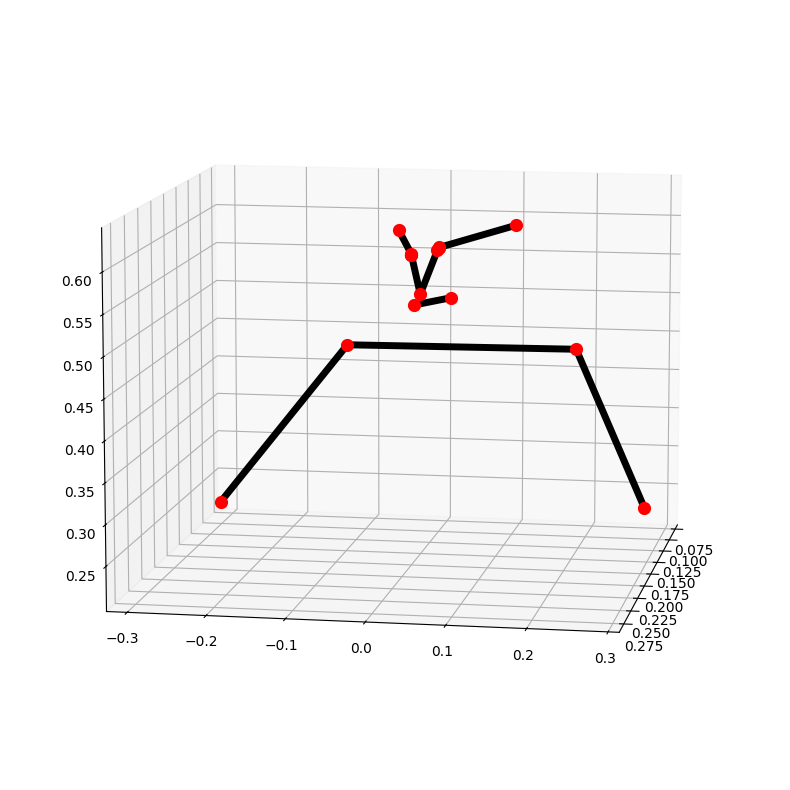

In [13]:
# 10-9

import cv2
import mediapipe as mp

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

pose = mp_pose.Pose(static_image_mode = False, enable_segmentation = True, min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)

while True:
    ret, frame = cap.read()

    if not ret:
        print('프레임 획득 실패, 루프 탈출')
        break

    res = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    mp_drawing.draw_landmarks(frame, res.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                              landmark_drawing_spec = mp_styles.get_default_pose_landmarks_style())
            

    cv2.imshow('MP pose', cv2.flip(frame, 1))

    if cv2.waitKey(5) == ord('q'):
        mp_drawing.plot_landmarks(res.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        break


cap.release()
cv2.destroyAllWindows()